<a href="https://colab.research.google.com/github/fmottes/jax-morph/blob/eqx">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="width:250px;"/>
  </a>

# Optimization of stochastic simulations

We now turn to the problem of optimizing a simulation that involves steps where some sort of sampling is involved. The sampling step is not differentiable in the classic sense, so it is not possible to propagate gradients through the simulation directly.

In this notebook we will use some toy problems to illustrate the basic variants of two mainstream approaches adopted to overcome the non-differentiability of the sampling step:

1. **Straight-Through Estimators**: The main idea is to carry out the sampling step as usual in the forward pass, but use a deterministic approximation during the gradient computation so as to bypass the non-differentiable operations. Heuristically, though, this approach work in simple settings but it is fairly hard to make it work in complex models like ours.

2. **Score Function Estimators**: The idea in this case is to use the score function to estimate the gradient of the expectation of the function of interest. This idea is at the core of the REINFORCE algorithm, the one we adopt also for the optimizations carried out in the paper.


In order to illustrate the problem and the two approaches mentioned above, we will explore two different cases of increasing complexity: sampling from a single **Bernoulli Random Variable** first, and then from a **Categorical Distribution**.

# Imports

In [41]:
import jax
import jax.numpy as np
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)

key = jax.random.PRNGKey(0) # random number generator

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

from tqdm import trange

import optax

# Bernoulli Random Variable

A Bernoulli random variable $X$ is a discrete random variable that takes on two possible outcomes, usually denoted as 0 and 1. The probability mass function of $X$ is given by:

$$
P(X = k) = 
\begin{cases} 
p & \text{if } k = 1 \\
1 - p & \text{if } k = 0
\end{cases}
$$

where $p$ is the probability of the event occurring (i.e., $X = 1$), and $1 - p$ is the probability of the event not occurring (i.e., $X = 0$).


We define the RV Z as distributed as Bernoulli 
$$ Z \sim \text{Bernoulli}(p) $$
and the outcome of our "simulation" will be a function of the value of Z. 


In order to avoid possible confusions deriving from 0 values, we also redefine the outcomes of Z as +1 and -1, instead of 1 and 0.

$$
P(X = k) = 
\begin{cases} 
p & \text{if } k = +1 \\
1 - p & \text{if } k = -1
\end{cases}
$$

In order to make things (slighty) less trivial, we will also suppose that the probability $p$ depends on a parameter $\theta$ that we want to learn. In particular, we will suppose that $p = \sigma(\theta)$, where $\sigma$ is the sigmoid function.

In [2]:
### SIMULATION STEPS

# calculate p given theta
p_fn = lambda theta: jax.nn.sigmoid(theta)


# sample from Bernoulli distribution given p
def sample_bernoulli(subkey, p):

    u = jax.random.uniform(subkey)

    # ±1 encoding instead of [0,1]
    return np.sign(p-u)


# deterministic part of the "simulation"
env_fn = lambda z: 2*z

In [3]:
### ENTIRE SIMULATION

def simulation(subkey, theta):

    p = p_fn(theta) # calculate p
    z = sample_bernoulli(subkey, p) # sample z
    outcome = env_fn(z) # simulate outcome

    return outcome

## The Gradient Problem

Now we can try to calculate the linear sensitivity of the model outcome with respect to the input parameter $\theta$.

The analytic expression for the gradient is:

$$
\frac{\partial \text{outcome}}{\partial \theta}  = \frac{\partial \text{outcome}}{\partial Z} \cdot \frac{\partial Z}{\partial p} \cdot \frac{\partial p}{\partial \theta}
$$

But the derivative
$$ \frac{\partial Z}{\partial p} =\ ?$$
is not defined, since Z is a discrete random variable. In this case, JAX will set the derivative to 0 and the whole expression will be 0 as expected.

In [4]:
theta = 1. # gives p = 0.73

key, subkey = jax.random.split(key)
o, g = jax.value_and_grad(simulation, argnums=1)(subkey, theta)

print(f'Simulation outcome:\t{o}')
print(f'Gradient wrt theta:\t{g}')

Simulation outcome:	2.0
Gradient wrt theta:	0.0


We can also check that each other step is well defined:

In [5]:
print(f'p = {p_fn(theta)} \t\t gradient = {jax.grad(p_fn)(theta)}')

print(f'z = {sample_bernoulli(subkey, .5)} \t\t\t gradient = {jax.grad(sample_bernoulli, argnums=1)(subkey, .5)}')

print(f'outcome = {env_fn(-1.)} \t\t\t gradient = {jax.grad(env_fn)(-1.)}')

p = 0.7310585786300049 		 gradient = 0.19661193324148185
z = -1.0 			 gradient = 0.0
outcome = -2.0 			 gradient = 2.0


## Solution 1: Straight-Through Estimator

One first fix is to decide on an arbitrary value (usually 1) to be assigned to the ill-defined derivative, so as to allow gradients to flow past the problematic point. This is the idea behind the Straight-Through Estimator and its more mathematically refined versions.

$$ \frac{\partial Z}{\partial p} \sim\ 1$$

We can easily do this in JAX by applying the following trick with `jax.lax.stop_gradient` (check the JAX docs for details).


In [6]:
def ST_sample_bernoulli(subkey, p):

    u = jax.random.uniform(subkey)
    z = np.sign(p-u)

    zero =  p - jax.lax.stop_gradient(p)

    #in the gradient calculation only the dependence on p remains, so the grad of the function is 1!!
    return zero + jax.lax.stop_gradient(z)

In [7]:
###  SIMULATION with ST step
###  Other steps are unchanged

def ST_simulation(subkey, theta):

    p = p_fn(theta) # calculate p
    z = ST_sample_bernoulli(subkey, p) # sample z
    outcome = env_fn(z) # simulate outcome

    return outcome

For one instance:

In [8]:
theta = 1. # gives p = 0.73

key, subkey = jax.random.split(key)
o, g = jax.value_and_grad(ST_simulation, argnums=1)(subkey, theta)

print(f'Simulation outcome:\t{o}')
print(f'Gradient wrt theta:\t{g}')

Simulation outcome:	2.0
Gradient wrt theta:	0.3932238664829637


Since the outcome of the simulation is stochastic, in order to get a better gradient we can get the expected gradient value over many simulations:

In [9]:
theta = 1. # gives p = 0.73

N_AVG = 1000

key, *subkeys = jax.random.split(key, N_AVG)
subkeys = np.asarray(subkeys)

o, g = jax.vmap(jax.value_and_grad(ST_simulation, argnums=1), in_axes=(0,None))(subkeys, theta)


print(f'Average simulation outcome:\t{o.mean()}')
print(f'Average gradient wrt theta:\t{g.mean()}')

Average simulation outcome:	0.9029029029029029
Average gradient wrt theta:	0.3932238664829637


Notice that this agrees with the previous calculation!

## Solution 2: Score Function Estimator (REINFORCE)

The second approach is to let go of all hope of calculating the gradient of a single simulation, and calculate the gradient of its **expected value** instead. It can be shown that the gradient of the expected value of a function of a random variable can be expressed in terms of the score function of the distribution of the random variable.

$$
\nabla_{\theta}\ \mathbb{E}_{\theta} [f(Z)] = \mathbb{E}_{\theta}\ [f(Z)\ \nabla_{\theta} \log P_{\theta}(Z)]
$$

That is, we now only need that the probability distribution from which we sample Z (Bernoulli in this specific case) be differentiable with respect to our parameters.

We can estimate the expectation numerically by running a lot of simulations and recording the outcomes and the log-probabilities of the outcomes. Then we can differentiate the log-probabilities instead of the simulations!


In [10]:
### log-probability of outcome
logp_fn = lambda z, p: np.log(p*(z==1) + (1-p)*(z==-1))


### Modify simulation to return logp too

def simulation_logp(subkey, theta):

    p = p_fn(theta) # calculate p
    z = sample_bernoulli(subkey, p) # sample z
    outcome = env_fn(z) # simulate outcome

    return outcome, logp_fn(z, p)

In order to make the gradient calculation more coincise, we can define a **surrogate loss**, which does not have a meaning *per se* but whose gradient is the the one we actually want.

In [11]:
def surrogate_loss(subkey, theta):

    outcome, logp = simulation_logp(subkey, theta)

    return jax.lax.stop_gradient(outcome)*logp

For one instance:

In [12]:
theta = 1. # gives p = 0.73

key, subkey = jax.random.split(key)
o = simulation(subkey, theta)
sl, g = jax.value_and_grad(surrogate_loss, argnums=1)(subkey, theta)

print(f'Simulation outcome:\t{o}')
print(f'Surrogate loss value\t{sl}')
print(f'Gradient wrt theta:\t{g}')

Simulation outcome:	-2.0
Surrogate loss value	2.6265233750364456
Gradient wrt theta:	1.4621171572600098


In order to get the true gradient we now have to get the expected value:

In [13]:
theta = 1. # gives p = 0.73

N_AVG = 1000

key, *subkeys = jax.random.split(key, N_AVG)
subkeys = np.asarray(subkeys)

o = jax.vmap(simulation, in_axes=(0,None))(subkeys, theta)
sl, g = jax.vmap(jax.value_and_grad(surrogate_loss, argnums=1), in_axes=(0,None))(subkeys, theta)


print(f'Average simulation outcome:\t{o.mean()}')
print(f'Average surrogate_loss value\t{sl.mean()}')
print(f'Average gradient wrt theta:\t{g.mean()}')

Average simulation outcome:	0.9189189189189189
Average surrogate_loss value	0.2526784493075791
Average gradient wrt theta:	0.7876759007183738


**NOTE:** While the average simulation outcome is the same in both cases (as it should be), the estimated gradient is different! Straight-through estimators and score function estimators have different characteristcs and are subject to different tradeoffs that can be found in the literature.

# Categorical Distributions

The same ideas can be translated almost unchanged to the case of a categorical distribution. A categorical distribution is a discrete distribution over a finite set of outcomes, each with a given probability. The probability mass function of a categorical distribution is given by:

$$
P(X = k) = 
\begin{cases}
p_k & \text{if } k = 1, \ldots, K \\
0 & \text{otherwise}
\end{cases}
$$

where $p_k$ is the probability of the $k$-th outcome.

This is the case that is the most similar to the model presented in the paper, where each category $k$ is a single cell with its associated probability of division $p_k$.


## A toy model (softmax growth)

In order to showcase the application of the previous ideas to the more relevant (for us) case of categorical distributions, we present a toy model with very simple rules that we will optimize with gradient descent.

The rules of the game are the following:
- We have three categories of objects. The **system state** $\bar x = (x_1, ..., x_N)$ is how many objects of each category we have at some point in time.
- At each time step, one category is chosen and an object of the same category added to it. Objects of each category are characterized by a "propensity" of division $\bar \beta = (\beta_1, ..., \beta_N)$.
- Category $k$ is chosen with probability 
$$ p_k = \text{softmax}_k(\bar \beta, \bar x) = \frac{\exp[-\beta_k x_k]}{\sum_i \exp[-\beta_i x_i]} $$
- One game is composed of $T$ rounds.


The aim of the optimization is to choose the propensities $\bar \beta$ in such a way that the system state at the end of the game is as close as possible to a target state $\bar x^*$. We will define the loss function as the squared distance between the final state and the target state:

$$ L_{\bar \beta}(\bar x_T) = \sum_i (x_i(T) - x_i^*)^2 $$

Note that in this case the dependency on $\bar \beta$ of the loss function is given by the fact that 
$$ \bar x(T) = \mathbb F_{\bar \beta}[\bar x(0)] $$

where $\mathbb F$ is the dynamics system state, which clearly depend on the chosen parameters. 

In [14]:
N = 3 # number of categories

T = 20 # number of time steps per simulation

In [15]:
# build target final state

tx1 = T//4
tx2 = T//7
tx3 = T - tx1 - tx2
target_x = np.array([tx1, tx2, tx3], dtype=np.float32)

print(f'Target final state:\t{target_x}')


# define square loss on state
def loss_x(x, target_x):
    return np.sum((x - target_x)**2)

Target final state:	[ 5.  2. 13.]


In [16]:
#generate probabilities
p_fn = lambda x, betas: jax.nn.softmax(-betas * x)

# sample category index
sample_category_idx = lambda subkey, p: jax.random.choice(subkey, len(p), p=p)

# update system state
update_state = lambda x, z: x + jax.nn.one_hot(z, len(x))

In [17]:
def simulation(subkey, x0, betas, T):

    def _sim_step(subkey, x, betas):

        p = p_fn(x, betas)
        z = sample_category_idx(subkey, p)
        x = update_state(x, z)

        return x
    
    subkeys = jax.random.split(subkey, T)

    x = x0
    for k in subkeys:
        x = _sim_step(k, x, betas)

    return x

In [18]:
### Carry out a trial simulation

x0 = np.zeros(N)
betas = np.ones(N)

key, subkey = jax.random.split(key)
xT = simulation(subkey, x0, betas, T)

print(f'Initial state:\t\t{x0}')
print(f'Final state:\t\t{xT}')
print(f'Target final state:\t{target_x}')

Initial state:		[0. 0. 0.]
Final state:		[6. 7. 7.]
Target final state:	[ 5.  2. 13.]


## Straight-Through Approach

In [19]:
def ST_sample_and_update(subkey, x, p):

    z = sample_category_idx(subkey, p)
    x = update_state(x, z)

    zero = p - jax.lax.stop_gradient(p)

    return zero + jax.lax.stop_gradient(x)

In [20]:
def ST_simulation(subkey, x0, betas, T):

    def _sim_step(subkey, x, betas):
        p = p_fn(x, betas)
        x = ST_sample_and_update(subkey, x, p)
        return x
    
    
    subkeys = jax.random.split(subkey, T)

    x = x0
    for k in subkeys:
        x = _sim_step(k, x, betas)

    return x

In [21]:
def ST_loss(subkey, x0, betas, T, target_x):

    x0 = np.asarray(x0)
    target_x = np.asarray(target_x)

    xT = ST_simulation(subkey, x0, betas, T)

    return loss_x(xT, target_x)

### Gradients

In [22]:
key, subkey = jax.random.split(key)
o, g = jax.value_and_grad(ST_loss, argnums=2)(subkey, x0, betas, T, target_x)

print('SINGLE RUN:\n-------------------\n')
print(f'Loss value:\t\t{o}')
print(f'Gradient wrt betas:\t{g}')

SINGLE RUN:
-------------------

Loss value:		62.0
Gradient wrt betas:	[  2.19537807 -12.47873912  12.58459586]


In [23]:
N_AVG = 1000

key, *subkeys = jax.random.split(key, N_AVG)
subkeys = np.asarray(subkeys)

o, g = jax.vmap(jax.value_and_grad(ST_loss, argnums=2), in_axes=(0,None,None,None,None))(subkeys, x0, betas, T, target_x)

print(f'AVERAGE OVER {N_AVG} RUNS:\n---------------------------\n')

print(f'Average loss value:\t\t{o.mean()}')
print(f'Average gradient wrt betas:\t{g.mean(0)}')

AVERAGE OVER 1000 RUNS:
---------------------------

Average loss value:		65.81581581581581
Average gradient wrt betas:	[ -4.52336734 -12.59177011  16.94207343]


### Optimization

In [24]:
#optimization hyperparameters
EPOCHS = 1000
LEARNING_RATE = 1e-2
BATCH_SIZE = 32
optimizer = optax.adam(LEARNING_RATE)

#initialize optimizer and parameters
opt_params = np.ones_like(betas)
opt_state = optimizer.init(opt_params)

losses = [] # to store the loss values

losses_and_grads_fn = jax.vmap(jax.value_and_grad(ST_loss, argnums=2), in_axes=(0,None,None,None,None))
losses_and_grads_fn = jax.jit(losses_and_grads_fn, static_argnums=(1,3,4))

# static arguments to exploit jit compilation
static_x0 = tuple(x0.tolist())
static_target_x = tuple(target_x.tolist())


pbar = trange(EPOCHS)
for epoch in pbar:

    # sample a batch of subkeys
    key, *subkeys = jax.random.split(key, BATCH_SIZE+1)
    subkeys = np.asarray(subkeys)

    # compute the loss and its gradient 
    loss, grad = losses_and_grads_fn(subkeys, static_x0, opt_params, T, static_target_x)

    # average over the batch
    loss = np.mean(loss)
    grad = np.mean(grad, axis=0)

    # update parameters
    updates, opt_state = optimizer.update(grad, opt_state, opt_params)
    opt_params = optax.apply_updates(opt_params, updates)
    

    # store the loss and update the progress bar
    losses.append(loss)
    pbar.set_description(f'Loss: {loss:.3f}')

Loss: 1.812: 100%|██████████| 1000/1000 [00:05<00:00, 181.04it/s]


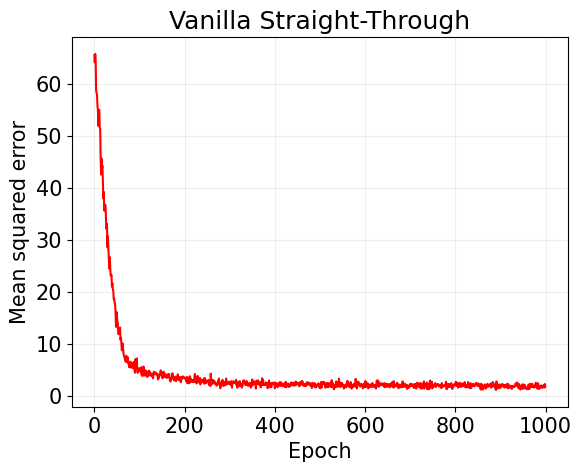

In [25]:
plt.plot(np.arange(EPOCHS), losses, 'r')

plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.title('Vanilla Straight-Through')

# plt.yscale('log')

plt.grid(alpha=.2)

plt.show()

We can run a single simulation to check that the final state is consistent with what we expect:

In [26]:
key, subkey = jax.random.split(key)
xT = ST_simulation(subkey, x0, opt_params, T)

print(f'Final state:\t{xT}')
print(f'Target state:\t{target_x}\n')
print(f'Loss:\t\t{loss_x(xT, target_x)}')

Final state:	[ 4.  3. 13.]
Target state:	[ 5.  2. 13.]

Loss:		2.0


### Gumbel-Softmax Straight-Through

We can implement a more refined version of straight-through estimation by following [Jang et al](https://arxiv.org/abs/1611.01144). The idea is to use the usual categorical distribution in the forward pass, but use the Gumbel-Softmax continuous relaxation of the same categorical distribution in the backward pass, in order to get a differentiable approximation of the sampling step. In this case it doesn't make much of a difference since the problem is very simple, but we show an example of how to implement it.

The **Gumbel-Softmax Distribution** is defined as:

$$
z = \text{softmax}((\log(p_i) + g_i) / \tau)
$$

where $g_i = -\log(-\log(u))$ is the Gumbel-distributed noise, and $\tau$ is a parameter that controls the interpolation between the categorical and a uniform distribution. As $\tau \to 0$, the Gumbel-Softmax distribution converges to the categorical distribution.

In [27]:
def GS_sample_and_update(subkey, x, p, tau):

    logits = np.log(p)
    gumbel = -np.log(-np.log(jax.random.uniform(subkey, shape=p.shape)))

    a = (logits + gumbel) / tau

    z = np.argmax(a)
    z_soft = jax.nn.softmax(a)

    x = update_state(x, z)

    zero = z_soft - jax.lax.stop_gradient(z_soft)

    return zero + jax.lax.stop_gradient(x)

In [28]:
def GS_simulation(subkey, x0, betas, T, tau=1.):

    def _sim_step(subkey, x, betas):
        p = p_fn(x, betas)
        x = GS_sample_and_update(subkey, x, p, tau)
        return x
    
    
    subkeys = jax.random.split(subkey, T)

    x = x0
    for k in subkeys:
        x = _sim_step(k, x, betas)

    return x

In [29]:
def GS_loss(subkey, x0, betas, T, target_x, tau=1.):

    x0 = np.asarray(x0)
    target_x = np.asarray(target_x)

    xT = GS_simulation(subkey, x0, betas, T, tau)

    return loss_x(xT, target_x)

#### Gradients

In [30]:
key, subkey = jax.random.split(key)
o, g = jax.value_and_grad(GS_loss, argnums=2)(subkey, x0, betas, T, target_x)

print('SINGLE RUN:\n-------------------\n')
print(f'Loss value:\t\t{o}')
print(f'Gradient wrt betas:\t{g}')

SINGLE RUN:
-------------------

Loss value:		78.0
Gradient wrt betas:	[  1.37860076 -20.28460228  18.68306961]


In [31]:
N_AVG = 1000

key, *subkeys = jax.random.split(key, N_AVG)
subkeys = np.asarray(subkeys)

o, g = jax.vmap(jax.value_and_grad(GS_loss, argnums=2), in_axes=(0,None,None,None,None))(subkeys, x0, betas, T, target_x)

print(f'AVERAGE OVER {N_AVG} RUNS:\n---------------------------\n')

print(f'Average loss value:\t\t{o.mean()}')
print(f'Average gradient wrt betas:\t{g.mean(0)}')

AVERAGE OVER 1000 RUNS:
---------------------------

Average loss value:		65.75775775775776
Average gradient wrt betas:	[ -4.0009507  -10.36731125  14.05505395]


#### Optimization

In [32]:
#optimization hyperparameters
EPOCHS = 1000
LEARNING_RATE = 1e-2
BATCH_SIZE = 32
optimizer = optax.adam(LEARNING_RATE)

#initialize optimizer and parameters
opt_params = np.ones_like(betas)
opt_state = optimizer.init(opt_params)

losses = [] # to store the loss values

losses_and_grads_fn = jax.vmap(jax.value_and_grad(GS_loss, argnums=2), in_axes=(0,None,None,None,None))
losses_and_grads_fn = jax.jit(losses_and_grads_fn, static_argnums=(1,3,4))

# static arguments to exploit jit compilation
static_x0 = tuple(x0.tolist())
static_target_x = tuple(target_x.tolist())


pbar = trange(EPOCHS)
for epoch in pbar:

    # sample a batch of subkeys
    key, *subkeys = jax.random.split(key, BATCH_SIZE+1)
    subkeys = np.asarray(subkeys)

    # compute the loss and its gradient 
    loss, grad = losses_and_grads_fn(subkeys, static_x0, opt_params, T, static_target_x)

    # average over the batch
    loss = np.mean(loss)
    grad = np.mean(grad, axis=0)

    # update parameters
    updates, opt_state = optimizer.update(grad, opt_state, opt_params)
    opt_params = optax.apply_updates(opt_params, updates)
    

    # store the loss and update the progress bar
    losses.append(loss)
    pbar.set_description(f'Loss: {loss:.3f}')

Loss: 1.562: 100%|██████████| 1000/1000 [00:07<00:00, 131.89it/s]


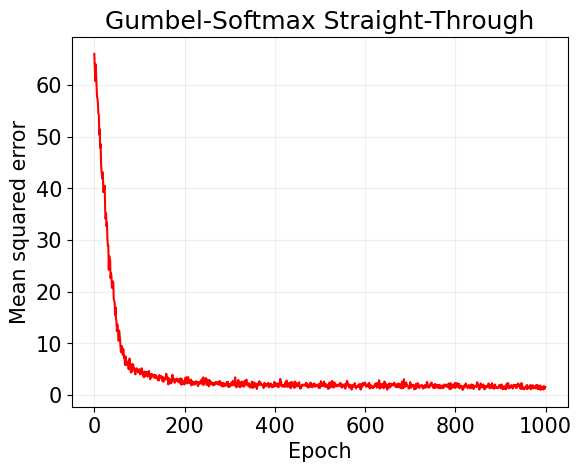

In [33]:
plt.plot(np.arange(EPOCHS), losses, 'r')

plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.title('Gumbel-Softmax Straight-Through')

# plt.yscale('log')

plt.grid(alpha=.2)

plt.show()

We can run a single simulation to check that the final state is consistent with what we expect:

In [34]:
key, subkey = jax.random.split(key)
xT = ST_simulation(subkey, x0, opt_params, T)

print(f'Final state:\t{xT}')
print(f'Target state:\t{target_x}\n')
print(f'Loss:\t\t{loss_x(xT, target_x)}')

Final state:	[ 6.  2. 12.]
Target state:	[ 5.  2. 13.]

Loss:		2.0


## REINFORCE Approach - (Vanilla) Policy Gradients

We assign a loss to each action taken, negative for good actions bringing us closer to the target and positive for bad actions. The reward is then used to estimate the gradient of the expected reward with respect to the parameters $\bar \beta$.

### Optimization

In [35]:
### Modify simulation to return logp and per-step loss

def PG_simulation(subkey, x0, betas, T):

    def _sim_step(subkey, x, betas):

        p = p_fn(x, betas)
        z = sample_category_idx(subkey, p)
        x = update_state(x, z)

        return x, np.log(p[z])
    
    subkeys = jax.random.split(subkey, T)

    logp_t = np.empty(T)

    x = x0
    for i, k in enumerate(subkeys):
        x, logp = _sim_step(k, x, betas)

        logp_t = logp_t.at[i].set(logp)

    return x, logp_t

In [36]:
def PG_loss(subkey, x0, betas, T, target_x, gamma=.95):

    x0 = np.asarray(x0)
    target_x = np.asarray(target_x)

    x, logp_t = PG_simulation(subkey, x0, betas, T)

    # loss calculated only on final state - can be made more genreal including all states in time
    loss = loss_x(x, target_x)

    # discount loss for prevoius time steps
    # idea: actions taken towards the end have a higher effect on the final state!
    discounted_losses = np.array([(gamma**(logp_t.shape[0]-i))*loss for i in np.arange(logp_t.shape[0])])

    loss = np.sum(logp_t*jax.lax.stop_gradient(discounted_losses))

    return loss


In [37]:
#optimization hyperparameters
EPOCHS = 1000
LEARNING_RATE = 1e-2
BATCH_SIZE = 32
optimizer = optax.adam(LEARNING_RATE)

#initialize optimizer and parameters
opt_params = np.ones_like(betas)
opt_state = optimizer.init(opt_params)

surr_losses = [] # to store the loss values
losses = [] 

slosses_and_grads_fn = jax.vmap(jax.value_and_grad(PG_loss, argnums=2), in_axes=(0,None,None,None,None))
slosses_and_grads_fn = jax.jit(slosses_and_grads_fn, static_argnums=(1,3,4))

loss_fn = jax.vmap(ST_loss, in_axes=(0,None,None,None,None))
loss_fn = jax.jit(loss_fn, static_argnums=(1,3,4))

# static arguments to exploit jit compilation
static_x0 = tuple(x0.tolist())
static_target_x = tuple(target_x.tolist())


pbar = trange(EPOCHS)
for epoch in pbar:

    # sample a batch of subkeys
    key, *subkeys = jax.random.split(key, BATCH_SIZE+1)
    subkeys = np.asarray(subkeys)

    # compute the surrogate loss and its gradient 
    surr_loss, grad = slosses_and_grads_fn(subkeys, static_x0, opt_params, T, static_target_x)

    # calculate actual loss for logging
    loss = loss_fn(subkeys, static_x0, opt_params, T, static_target_x)

    # average over the batch
    surr_loss = np.mean(surr_loss)
    grad = np.mean(grad, axis=0)
    loss = np.mean(loss)


    # update parameters
    updates, opt_state = optimizer.update(grad, opt_state, opt_params)
    opt_params = optax.apply_updates(opt_params, updates)


    # store the loss and update the progress bar
    surr_losses.append(surr_loss)
    losses.append(loss)
    pbar.set_description(f'Loss: {loss:.3f}')

Loss: 1.062: 100%|██████████| 1000/1000 [00:08<00:00, 123.65it/s]


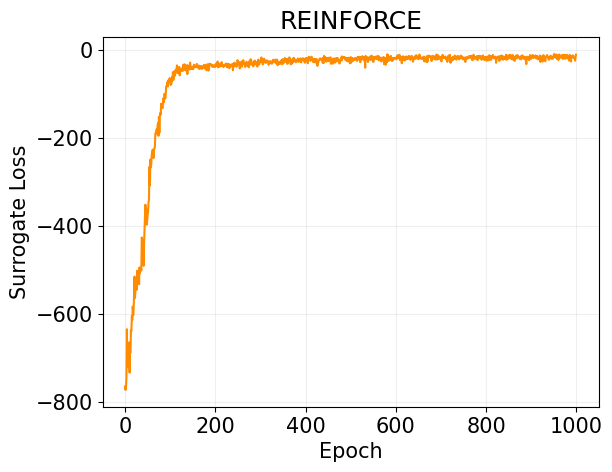

In [38]:
plt.plot(np.arange(EPOCHS), surr_losses, 'darkorange')

plt.xlabel('Epoch')
plt.ylabel('Surrogate Loss')
plt.title('REINFORCE')


plt.grid(alpha=.2)

plt.show()

We can run a single simulation to check that the final state is consistent with what we expect:

In [39]:
key, subkey = jax.random.split(key)
xT, lp = PG_simulation(subkey, x0, opt_params, T)

print(f'Final state:\t{xT}')
print(f'Target state:\t{target_x}\n')
print(f'Loss:\t\t{loss_x(xT, target_x)}')

Final state:	[ 5.  3. 12.]
Target state:	[ 5.  2. 13.]

Loss:		2.0


**NOTE:** The surrogate loss in this case goes up! This makes sense if we consider that the loss is the sum of the log-likelihoods of the actions taken during the "game". During a random game the actions are taken all more or less with the same probability (of order 1/N - so log(p) will be very negative) and they will all be pretty bad, giving very high losses that multiply the log-likelihoods. At the end of the training the loss should go towards 0 and the agent should be more sure of what to do, choosing actions with much higher probabilities. Both of these conditions make the surrogate loss increase towards 0.

We can also check that the actual loss we want to minimize decreases instead.

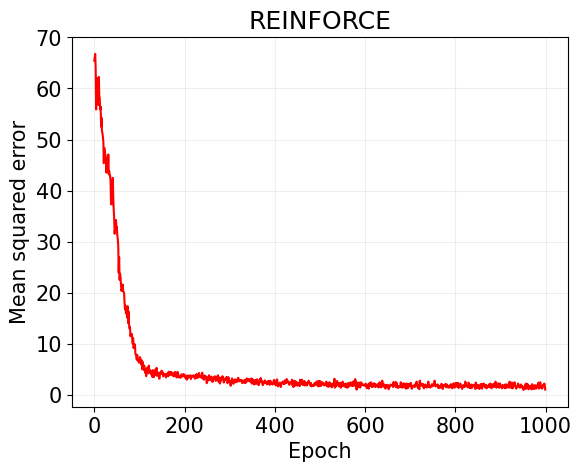

In [40]:
plt.plot(np.arange(EPOCHS), losses, 'r')

plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.title('REINFORCE')


plt.grid(alpha=.2)

plt.show()